In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels as sm
from sklearn.linear_model import LogisticRegression, LinearRegression
# set up path to import my python scripts
import sys
import os
src_path = os.path.abspath(os.path.join('..'))
if src_path not in sys.path:
    sys.path.append(src_path+"/src")
    
%load_ext autoreload
%autoreload 2
import clean_df

#import data from 2013-2014 NHANES: https://www.kaggle.com/cdc/national-health-and-nutrition-examination-survey
#description of columns: https://wwwn.cdc.gov/nchs/nhanes/2013-2014/demo_h.htm
demo_df = pd.read_csv('../data/demographic.csv')
diet_df = pd.read_csv('../data/diet.csv')
exam_df = pd.read_csv('../data/examination.csv')
labs_df = pd.read_csv('../data/labs.csv')
med_df = pd.read_csv('../data/medications.csv', encoding='latin1')
ques_df = pd.read_csv('../data/questionnaire.csv')

### Step 1: EDA

In [2]:
new_demo_df = demo_df[['SEQN','RIAGENDR','RIDAGEYR','RIDRETH3',
'DMQMILIZ','DMQADFC','DMDBORN4','DMDMARTL']]

In [3]:
'''
demo_df feature descriptions:
------------------------------
SEQN: Participant sequence number
RIAGENDR: Particpant gender
	1 -> Male
	2 -> Female
RIDAGEYR: Age in years
RIDRETH3: Race/Hispanic origin w/ NH Asian
	1 -> Mexican American
	2 -> Other Hispanic
	3 -> Non-Hispanic White
	4 -> Non-Hispanic Black
	6 -> Non-Hispanic Asian
	7 -> Other Race - Including Multi-Racial
DMQMILIZ: Served active duty in US Armed Forces
	1 -> Yes
	2 -> No
	7 -> Refused
	9 -> Don't Know
	. -> Missing
DMQADFC: Served in a foreign country
	1 -> Yes
	2 -> No
	7 -> Refused
	9 -> Don't Know
	. -> Missing
DMDBORN4: Country of birth
	1 -> Born in US
	2 -> Others
	77 -> Refused
	99 -> Don't Know
	. -> Missing
DMDMARTL: Marital Status
	1 -> Married
	2 -> Widowed
	3 -> Divorced
	4 -> Separated
	5 -> Never married
	6 -> Living with partner
	77 -> Refused
	99 -> Don't Know
	. -> Missing
'''

"\ndemo_df feature descriptions:\n------------------------------\nSEQN: Participant sequence number\nRIAGENDR: Particpant gender\n\t1 -> Male\n\t2 -> Female\nRIDAGEYR: Age in years\nRIDRETH3: Race/Hispanic origin w/ NH Asian\n\t1 -> Mexican American\n\t2 -> Other Hispanic\n\t3 -> Non-Hispanic White\n\t4 -> Non-Hispanic Black\n\t6 -> Non-Hispanic Asian\n\t7 -> Other Race - Including Multi-Racial\nDMQMILIZ: Served active duty in US Armed Forces\n\t1 -> Yes\n\t2 -> No\n\t7 -> Refused\n\t9 -> Don't Know\n\t. -> Missing\nDMQADFC: Served in a foreign country\n\t1 -> Yes\n\t2 -> No\n\t7 -> Refused\n\t9 -> Don't Know\n\t. -> Missing\nDMDBORN4: Country of birth\n\t1 -> Born in US\n\t2 -> Others\n\t77 -> Refused\n\t99 -> Don't Know\n\t. -> Missing\nDMDMARTL: Marital Status\n\t1 -> Married\n\t2 -> Widowed\n\t3 -> Divorced\n\t4 -> Separated\n\t5 -> Never married\n\t6 -> Living with partner\n\t77 -> Refused\n\t99 -> Don't Know\n\t. -> Missing\n"

In [4]:
new_df = clean_df.DemographicDF()
exam_df = clean_df.ExamDF()
new_df.left_merge(exam_df)
labs_df = clean_df.LabsDF()
new_df.left_merge(labs_df)
ques_df = clean_df.QuestDF()
new_df.left_merge(ques_df)

In [5]:
new_df.df.head()

,SEQN,RIAGENDR,RIDAGEYR,RIDRETH3,DMQMILIZ,DMQADFC,DMDBORN4,DMDMARTL,AVG SYS BP,AVG DIAS BP,High SYS BP?,High DIAS BP?,LBXHCT,LBXTR,BPQ020,BPQ080,BPQ040A,BPQ050A,BPQ090D
0,73557,Male,69,Black,Yes,Yes,Born in US,Separated,112.666667,74.000000,False,False,45.4,NaN,Yes,Yes,Yes,No,Yes
1,73558,Male,54,White,No,NaN,Born in US,Married,157.333333,61.333333,True,False,36.7,NaN,Yes,Yes,No,NaN,Yes
2,73559,Male,72,White,Yes,Yes,Born in US,Married,142.000000,82.000000,True,True,49.9,51.0,Yes,Yes,Yes,Yes,Yes
3,73560,Male,9,White,NaN,NaN,Born in US,NaN,104.666667,36.666667,False,False,37.8,NaN,NaN,NaN,NaN,NaN,NaN
4,73561,Female,73,White,No,NaN,Born in US,Married,137.333333,86.666667,True,True,43.8,75.0,Yes,No,Yes,Yes,No


In [6]:
test_df = new_df.df
nicotine = test_df['LBXHCT']
avg_sys_bp = test_df['AVG SYS BP']

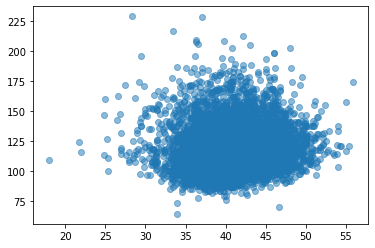

In [7]:
#AVG Systolic BP vs Nicotine (Hydroxycotinine, Serum (ng/mL))
fig, ax = plt.subplots()

# x = test_df['LBXHCT']
# y = test_df['AVG SYS BP']

ax = plt.scatter(x=nicotine,y=avg_sys_bp,alpha=0.5)

plt.show()

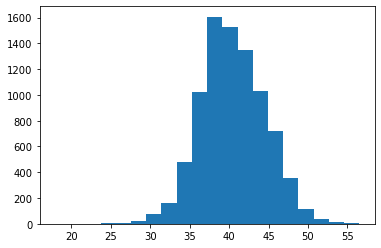

In [8]:
fig, ax = plt.subplots()

ax = plt.hist(x=nicotine,bins=20)

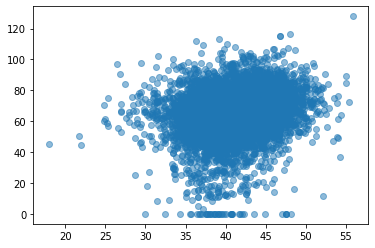

In [9]:
#AVG Diastolic BP vs Nicotine (Hydroxycotinine, Serum (ng/mL))
fig, ax = plt.subplots()

x = test_df['LBXHCT']
y = test_df['AVG DIAS BP']

ax = plt.scatter(x=x,y=y,alpha=0.5)

plt.show()

TypeError: numpy boolean subtract, the `-` operator, is not supported, use the bitwise_xor, the `^` operator, or the logical_xor function instead.

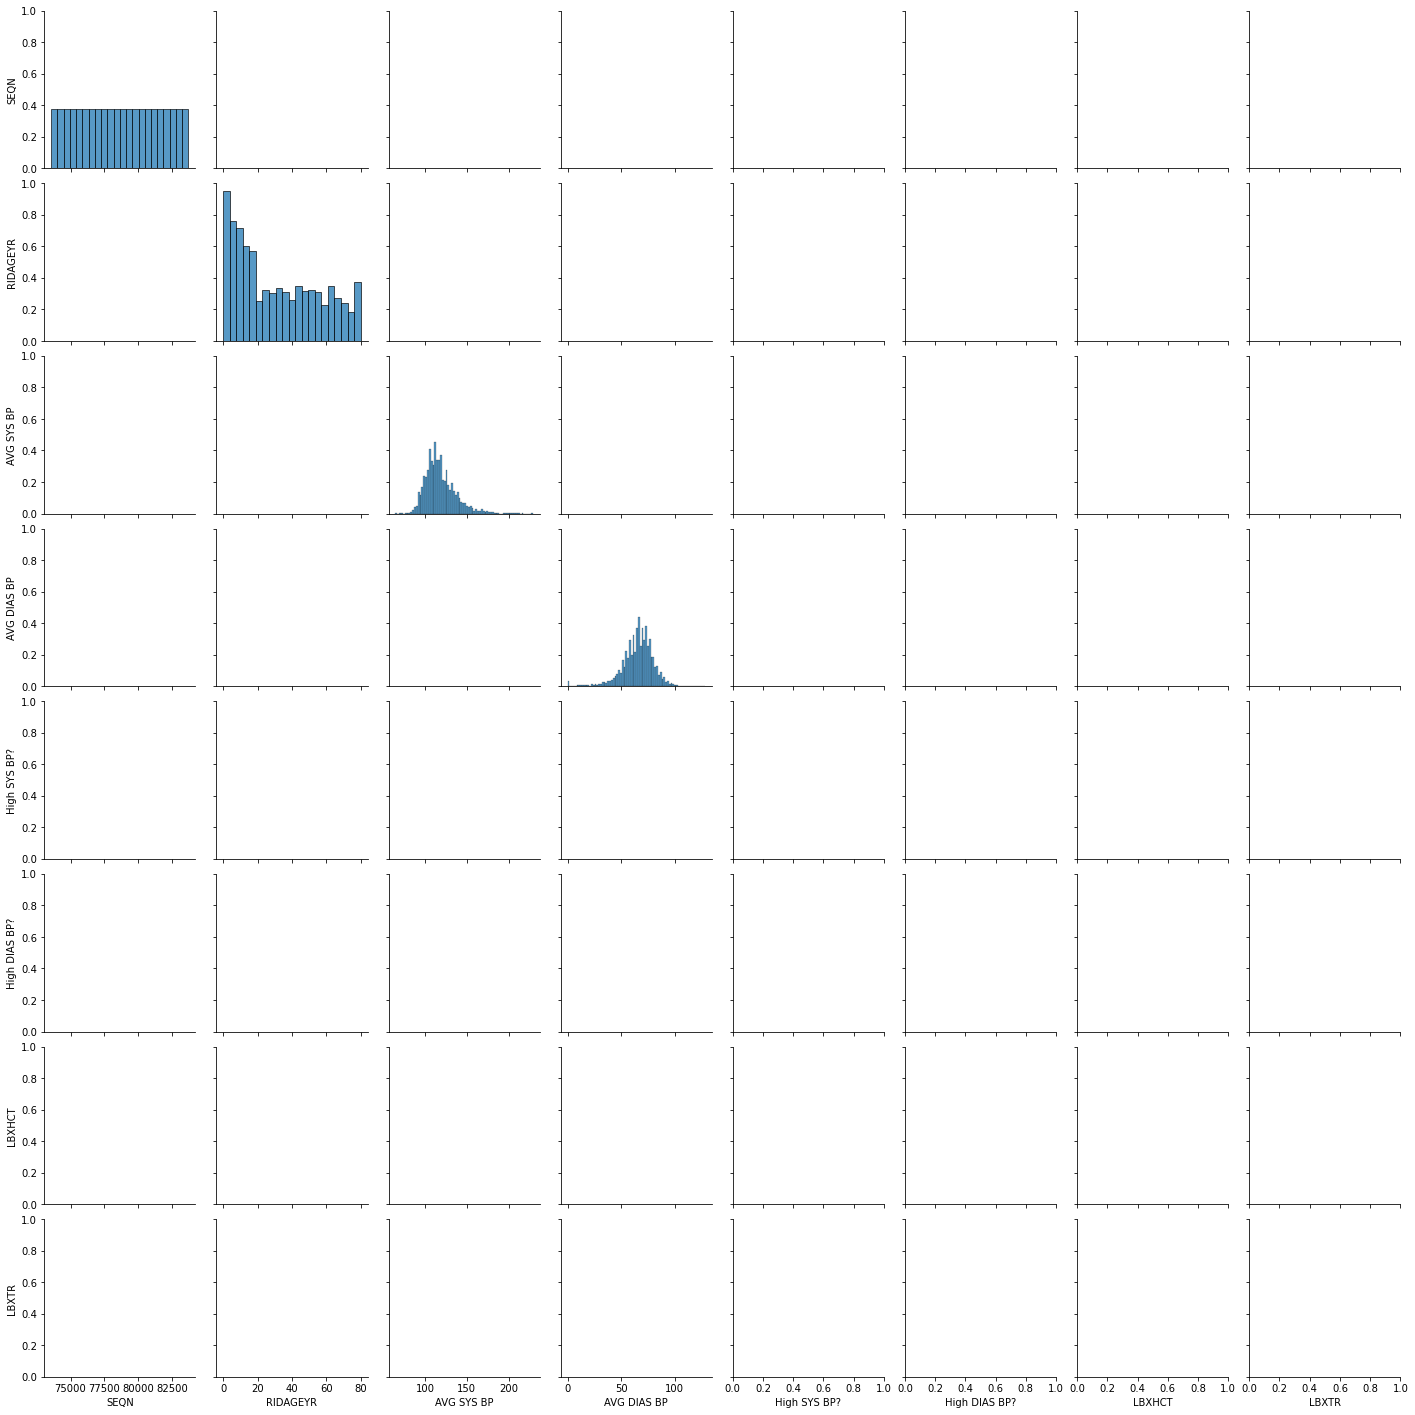

In [10]:
sns.pairplot(new_df.df)

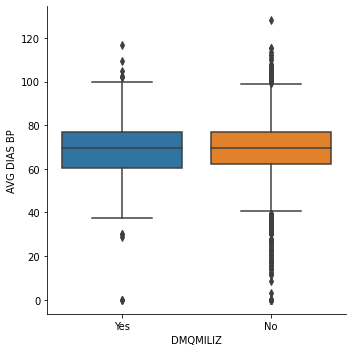

In [ ]:
sns.catplot(x='DMQMILIZ', y='AVG DIAS BP',kind='box',data=test_df)

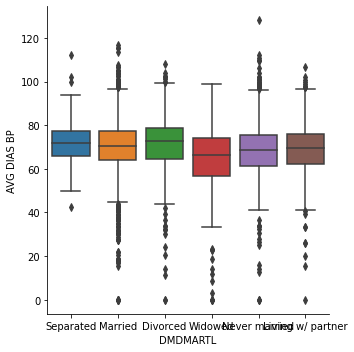

In [ ]:
sns.catplot(x='DMDMARTL', y='AVG DIAS BP',kind='box', data=test_df)

<AxesSubplot:xlabel='LBXHCT', ylabel='High DIAS BP?'>

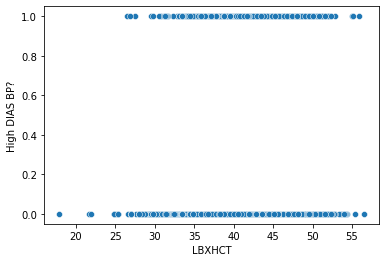

In [ ]:
sns.scatterplot(x='LBXHCT', y='High DIAS BP?',data=test_df)

<AxesSubplot:xlabel='LBXHCT', ylabel='High SYS BP?'>

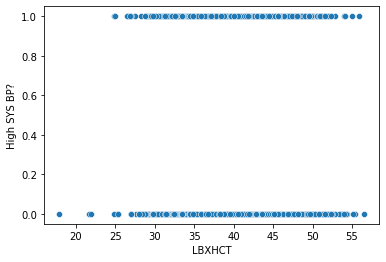

In [ ]:
sns.scatterplot(x='LBXHCT', y='High SYS BP?',data=test_df)

In [52]:
xy_values = test_df[test_df['LBXHCT']>-1]
xy_values = xy_values[xy_values['High SYS BP?']>-1].sort_values(by='LBXHCT')
x_values = xy_values['LBXHCT'].to_numpy().reshape(-1,1)
y_values = xy_values['High SYS BP?'].to_numpy().astype('int')

#xy_values.head()
print(type(y_values))

model = LogisticRegression()
model.fit(X=x_values,y=y_values)

y_hat_probs = model.predict_proba(x_values)[:,1]
threshold = 0.15
y_hat = (y_hat_probs >= threshold).astype('int')


<class 'numpy.ndarray'>


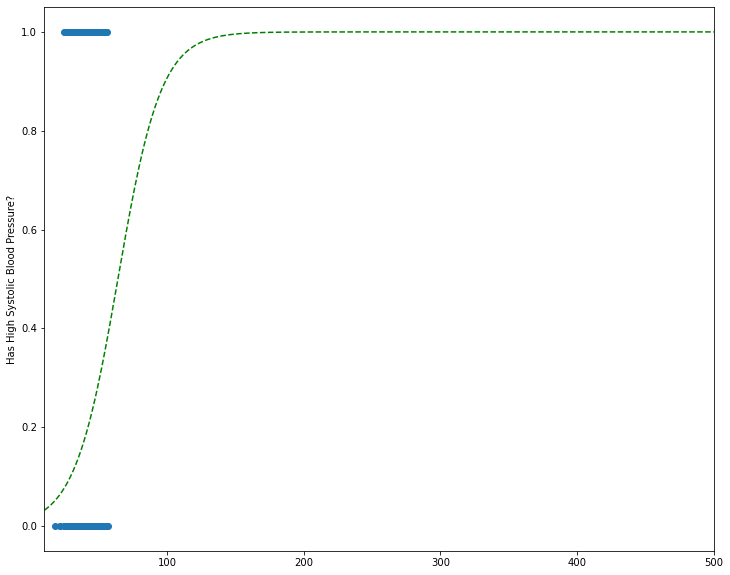

In [58]:
x = np.linspace(0,500,500).reshape(-1,1)

fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111)
ax.scatter(x_values, y_values, cmap='bwr')
ax.plot(x, model.predict_proba(x)[:,1], 'g--', label='probability of horse')
ax.set_xlim([10,500])
# ax.set_ylim([-0.2,1.201])
# ax.set_xlabel('Weight (lb)',fontsize=font_size)
ax.set_ylabel('Has High Systolic Blood Pressure?')
# ax.set_title('Horseness vs. weight',fontsize=font_size)
plt.show()